In [17]:
from tools.utils import *
from tools.het_networks import *
from itertools import product

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
# Random
seed = 40

# Model
hidden_channels = 256
num_classes = 6
num_layers = 2
intra_aggr='sum'
inter_aggr='mean'
dropout = 0.6
use_skip_connections = True
batch_size = 8
epochs = 45
decay = 2.5e-4
lr = 5e-4
maxlr = 5e-4

# Preprocessing

In [19]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [20]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [21]:
# Construct het dataset
het_dataset = []
for hom_data in normalized_hom_dataset_attr:
    het_data = convert_hom_to_het(hom_data, onehot_indices=[18, 19, 20], is_directed=False)
    het_dataset.append(het_data)
het_dataset.__len__()

600

In [22]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'edge_index', 'A'),
  ('A', 'edge_index', 'B'),
  ('A', 'edge_index', 'C'),
  ('B', 'edge_index', 'B'),
  ('B', 'edge_index', 'C'),
  ('C', 'edge_index', 'C')])

In [23]:
# Create splits
labels = [data.y.item() for data in het_dataset]

train_set, temp_set = train_test_split(
    het_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Test Set on Final HeteroGNN

Epoch 1/45
Train Loss: 1.8058 | Validation Loss: 1.7892 | Test Loss: 1.7915
Train Acc: 0.1381 | Validation Acc: 0.1889 | Test Acc: 0.2000
Train F1: 0.0979 | Validation F1: 0.0979 | Test F1: 0.1015

Epoch 2/45
Train Loss: 1.7957 | Validation Loss: 1.7836 | Test Loss: 1.7862
Train Acc: 0.1952 | Validation Acc: 0.2000 | Test Acc: 0.2222
Train F1: 0.1613 | Validation F1: 0.1162 | Test F1: 0.1370

Epoch 3/45
Train Loss: 1.7948 | Validation Loss: 1.7749 | Test Loss: 1.7793
Train Acc: 0.1833 | Validation Acc: 0.2111 | Test Acc: 0.2444
Train F1: 0.1380 | Validation F1: 0.1256 | Test F1: 0.1561

Epoch 4/45
Train Loss: 1.7912 | Validation Loss: 1.7643 | Test Loss: 1.7700
Train Acc: 0.1643 | Validation Acc: 0.2556 | Test Acc: 0.2222
Train F1: 0.1581 | Validation F1: 0.2252 | Test F1: 0.1531

Epoch 5/45
Train Loss: 1.7807 | Validation Loss: 1.7464 | Test Loss: 1.7535
Train Acc: 0.1690 | Validation Acc: 0.2667 | Test Acc: 0.2222
Train F1: 0.1477 | Validation F1: 0.2100 | Test F1: 0.1650

Epoch 6/45

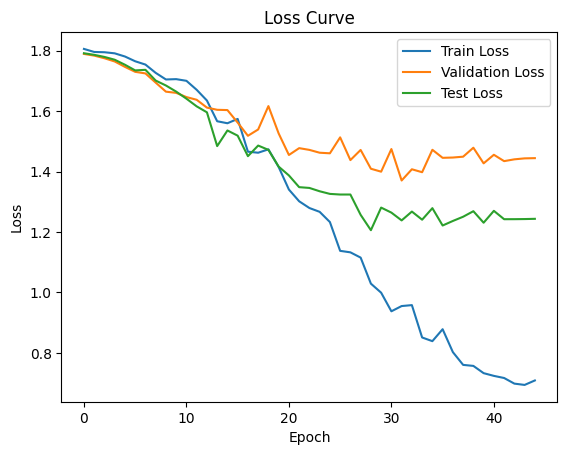

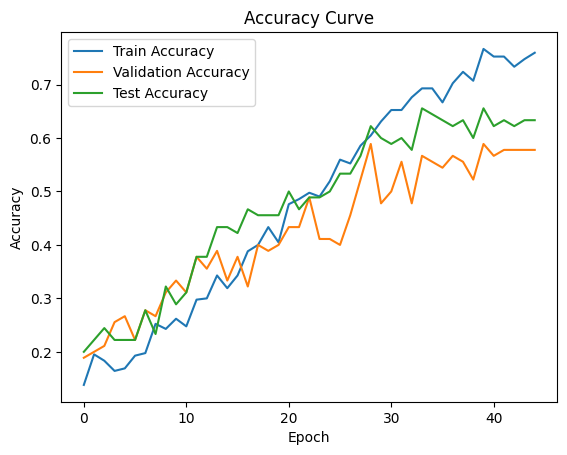

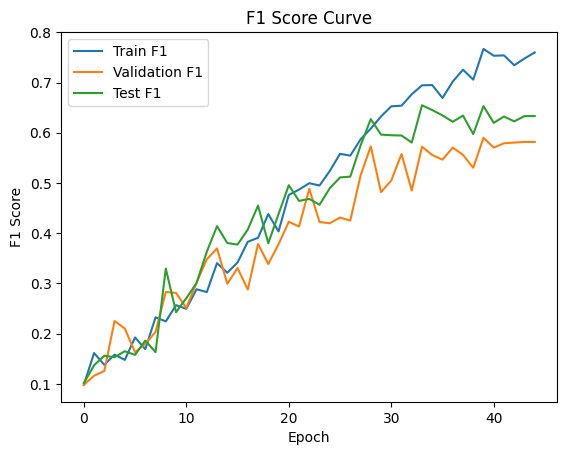

,Epoch,Train Loss,Valid Loss,Test Loss,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,Test F1
0,1,1.8058,1.7892,1.7915,0.1381,0.1889,0.2000,0.0979,0.0979,0.1015
1,2,1.7957,1.7836,1.7862,0.1952,0.2000,0.2222,0.1613,0.1162,0.1370
2,3,1.7948,1.7749,1.7793,0.1833,0.2111,0.2444,0.1380,0.1256,0.1561
3,4,1.7912,1.7643,1.7700,0.1643,0.2556,0.2222,0.1581,0.2252,0.1531
4,5,1.7807,1.7464,1.7535,0.1690,0.2667,0.2222,0.1477,0.2100,0.1650
5,6,1.7649,1.7300,1.7347,0.1929,0.2222,0.2222,0.1923,0.1630,0.1577
6,7,1.7540,1.7247,1.7367,0.1976,0.2778,0.2778,0.1692,0.1796,0.1862
7,8,1.7266,1.6943,1.7011,0.2524,0.2667,0.2333,0.2325,0.2034,0.1631
8,9,1.7047,1.6644,1.6848,0.2429,0.3111,0.3222,0.2244,0.2830,0.3296
9,10,1.7058,1.6604,1.6645,0.2619,0.3333,0.2889,0.2567,0.2810,0.2427


In [24]:
experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'test_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'test_acc': [],
    'train_f1': [],
    'valid_f1': [],
    'test_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    test_loss, test_acc, test_f1 = test(model, test_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['test_loss'].append(test_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['test_acc'].append(test_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    metrics['test_f1'].append(test_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f} | Test Loss: {test_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f} | Test Acc: {test_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f} | Test F1: {test_f1:.4f}\n")
plot_metrics_w_test(metrics, experiment_name)
create_metrics_table_w_test(metrics, experiment_name)